# Analyzing GRB 080916C
![Alt text](https://astrobites.org/wp-content/uploads/2014/10/NASAGRBwhoa-1024x576.jpg)
*(NASA/Swift/Cruz deWilde)*

To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

3ML provides utilities to reduce time series data to plugins in a *correct* and *statistically justified* way (e.g., background fitting of Poisson data is done with a Poisson likelihood). The approach is generic and can be extended. For more details, see the [time series documentation](https://threeml.readthedocs.io/en/stable/notebooks/Building_Plugins_from_TimeSeries.html).

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")


from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [4]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

02:39:27 INFO      The cache for fermigbrst does not yet exist. We will try to    ]8;id=203744;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=379956;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#64\64]8;;\
                  build it                                                                                         
                                                                                                                   

         INFO      Building cache for fermigbrst                                 ]8;id=141190;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=586121;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#112\112]8;;\

name,ra,dec,trigger_time,t90
object,float64,float64,float64,float64
GRB080916009,119.800,-56.600,54725.0088613,62.977


To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [5]:
grb_info = gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [6]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                value min_value max_value            unit
GRB080916009...K             0.012255       0.0      None  keV-1 s-1 cm-2
GRB080916009...alpha        -1.130424      -1.5       2.0                
GRB080916009...break_energy  309.2031      10.0      None             keV
GRB080916009...break_scale        0.3       0.0      10.0                
GRB080916009...beta         -2.096931      -5.0      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database.



In [7]:
dload = download_GBM_trigger_data("bn080916009", detectors=gbm_detectors)

Let's first examine the catalog fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background.
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/4 [00:00<?, ?it/s]

02:40:19 INFO      Auto-determined polynomial order: 0                                ]8;id=85635;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=774619;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

02:40:29 INFO      None 0-order polynomial fit with the mle method                               ]8;id=541196;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=965004;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=57123;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=197134;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=9275;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=850109;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

02:40:30 INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=644543;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=195801;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=975111;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=855318;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

02:40:31 INFO      Auto-probed noise models:                                                    ]8;id=642256;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=395847;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#490\490]8;;\

         INFO      - observation: poisson                                                       ]8;id=244201;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=898193;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#491\491]8;;\

         INFO      - background: gaussian                                                       ]8;id=676483;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=247936;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#492\492]8;;\

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=347573;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=500362;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

02:40:36 INFO      Now using 120 bins                                                          ]8;id=331864;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=841451;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/4 [00:00<?, ?it/s]

02:40:38 INFO      Auto-determined polynomial order: 1                                ]8;id=679182;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=314958;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_04 background:   0%|          | 0/128 [00:00<?, ?it/s]

02:40:50 INFO      None 1-order polynomial fit with the mle method                               ]8;id=591592;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=322460;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n4_bkg.h5                                         ]8;id=584959;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=381569;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n4_bkg.h5                                         ]8;id=298602;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=155050;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n4_bkg.h5                              ]8;id=346921;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=444068;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=527795;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=491592;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=992562;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=658671;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#490\490]8;;\

         INFO      - observation: poisson                                                       ]8;id=133906;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=55385;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#491\491]8;;\

         INFO      - background: gaussian                                                       ]8;id=249914;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=394416;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#492\492]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=271828;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=907127;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=969985;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=412312;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/4 [00:00<?, ?it/s]

02:40:52 INFO      Auto-determined polynomial order: 1                                ]8;id=295629;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=401317;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

02:41:02 INFO      None 1-order polynomial fit with the mle method                               ]8;id=383178;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=869683;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=954119;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=173556;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=499770;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=167025;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

02:41:03 INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=991231;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=989574;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=642498;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=56958;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

02:41:04 INFO      Auto-probed noise models:                                                    ]8;id=147062;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=96865;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#490\490]8;;\

         INFO      - observation: poisson                                                       ]8;id=898940;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=971687;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#491\491]8;;\

         INFO      - background: gaussian                                                       ]8;id=63528;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=718214;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#492\492]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=623174;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=688761;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=671518;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=712787;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

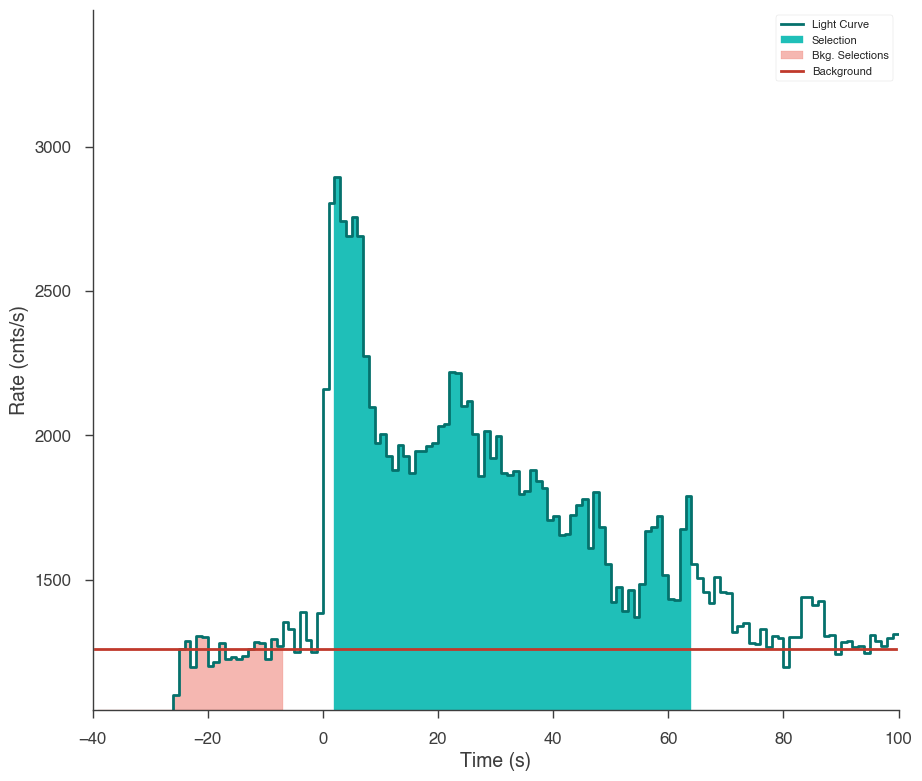

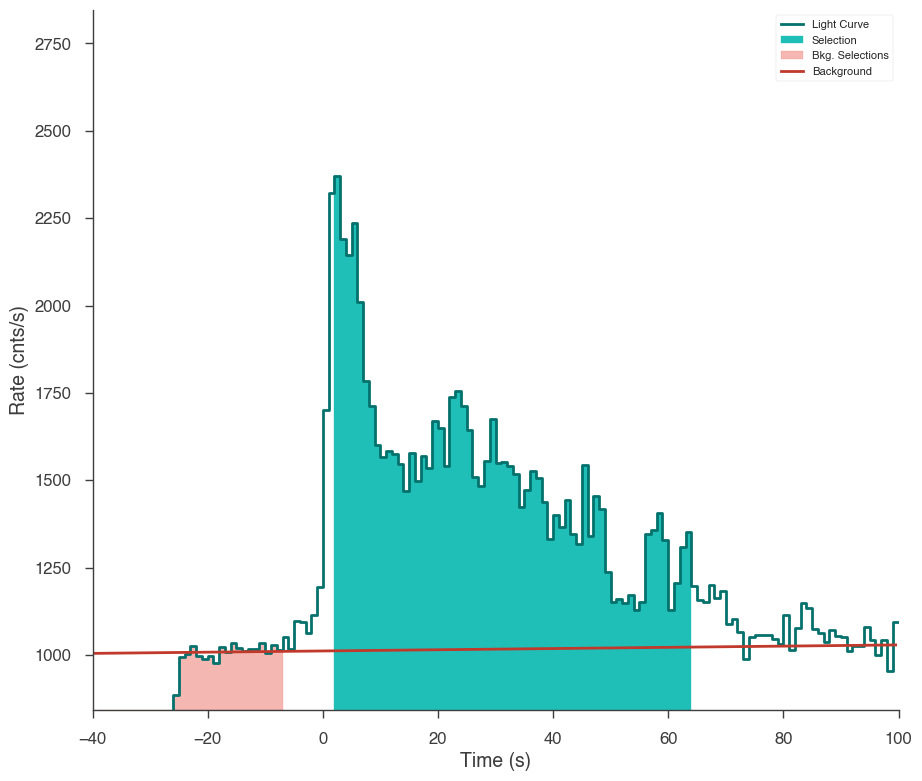

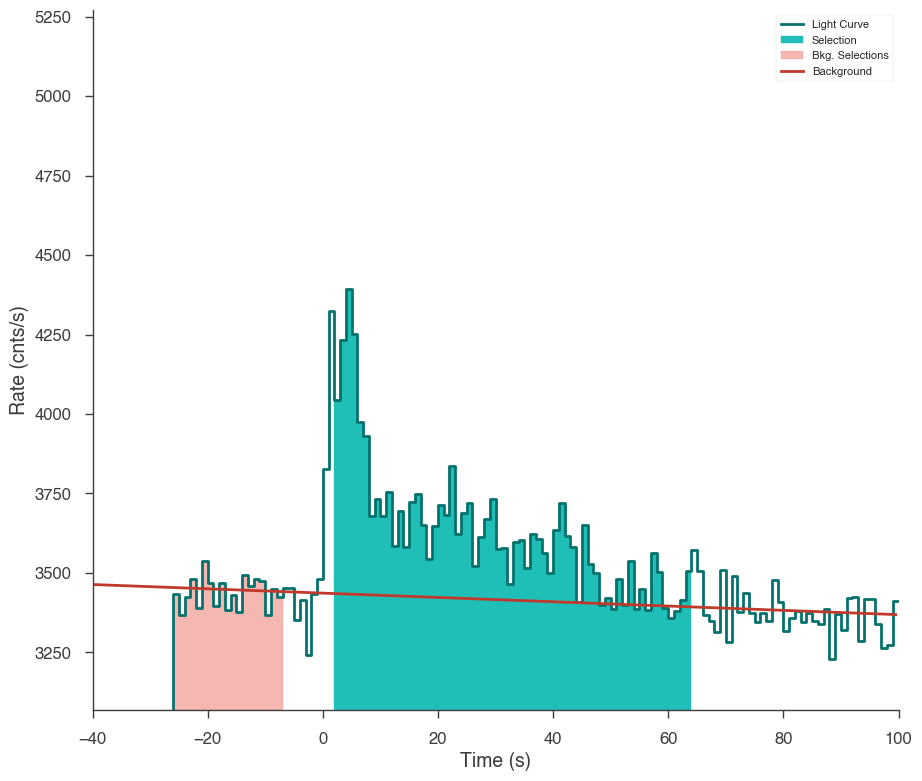

In [8]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:
    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):
        fluence_plugin.set_active_measurements("250-30000")

    else:
        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog.

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters.


In [9]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(
    lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(
    lower_bound=-5, upper_bound=-1.6, mu=-2.25, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(
    lower_bound=1e-3, upper_bound=1e1
)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(
    lower_bound=1e-4, upper_bound=10
)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest.

In [10]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))

# share spectrum gives a linear speed up when
# spectrumlike plugins have the same RSP input energies
bayes.set_sampler("multinest", share_spectrum=True)

02:41:05 INFO      sampler set to multinest                                                ]8;id=419474;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=168563;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.

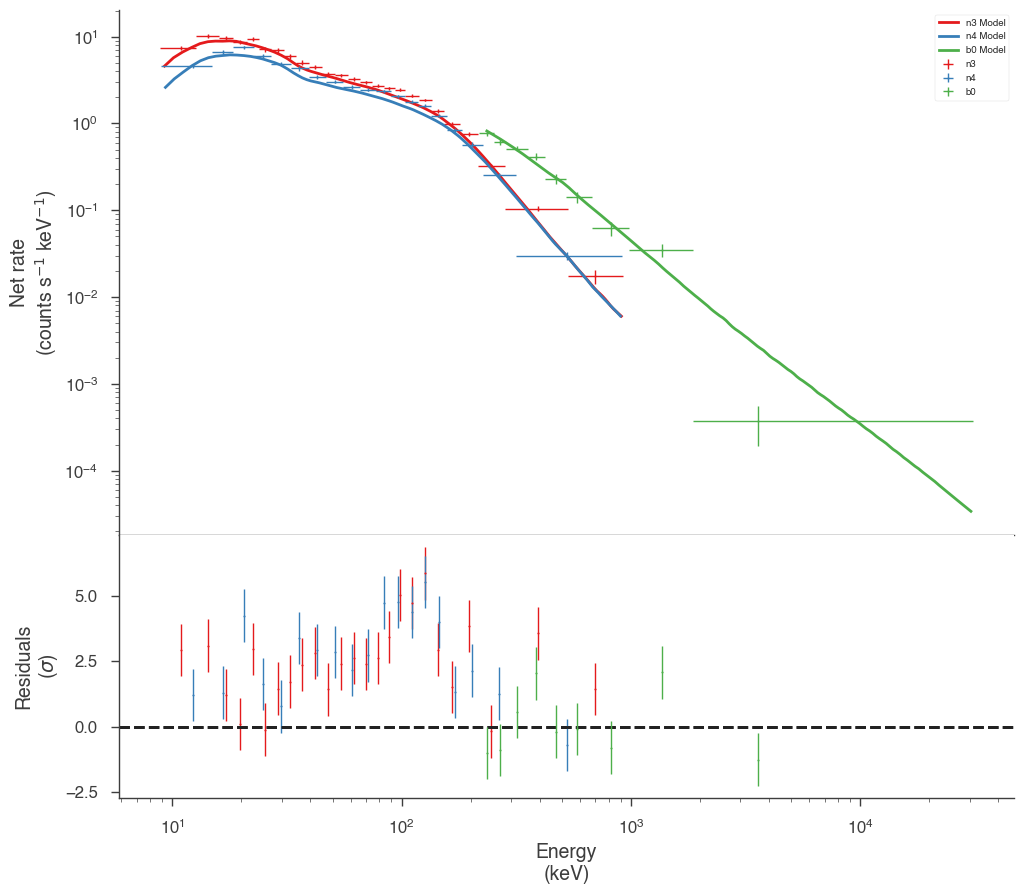

In [11]:
fig = display_spectrum_model_counts(bayes, min_rate=20, step=False)

### Run the sampler
We let MultiNest condition the model on the data

In [12]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -3107.9723496513743      +/-  0.24214861000214391     
 Total Likelihood Evaluations:        20336
 Sampling finished. Exiting MultiNest



02:41:24 INFO      fit restored to maximum of posterior                                         ]8;id=961379;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=266122;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=562462;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=577535;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
GRB080916009...K,(1.48394 -0.00025 +0.04) x 10^-2,1 / (cm2 keV s)
GRB080916009...alpha,-1.0848 -0.0009 +0.04,
GRB080916009...break_energy,(1.88 -0.21 -0.07) x 10^2,keV
GRB080916009...break_scale,(1.30 -0.32 +0.6) x 10^-1,
GRB080916009...beta,-1.975 +0.016 +0.07,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0,-1055.829508
n3,-1025.885913
n4,-1015.815172
total,-3097.530593


Values of statistical measures:

,statistical measures
AIC,6205.231640
BIC,6224.463851
DIC,6183.032453
PDIC,3.495608
log(Z),-1349.775241


Now our model seems to match much better with the data!

         INFO      fit restored to median of posterior                                          ]8;id=575145;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=422621;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

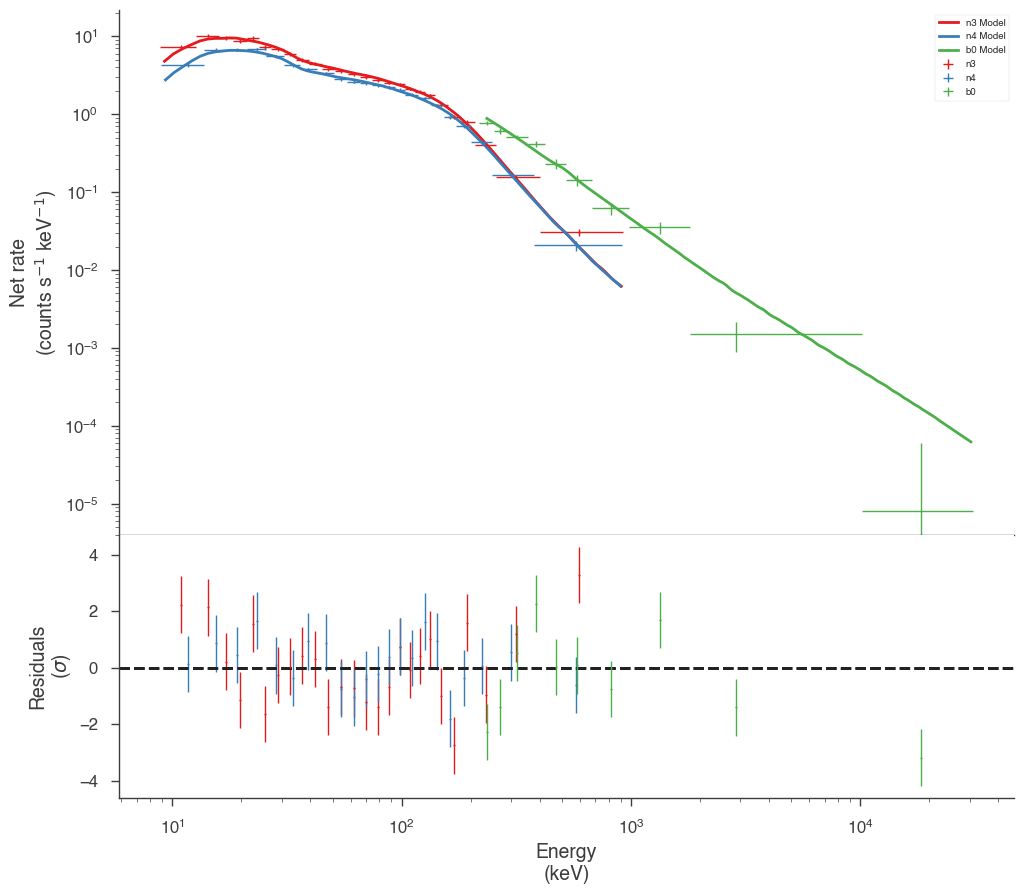

In [13]:
bayes.restore_median_fit()
fig = display_spectrum_model_counts(bayes, min_rate=20)

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [14]:
conversion = u.Unit("keV2/(cm2 s keV)").to("erg2/(cm2 s keV)")
energy_grid = np.logspace(1, 4, 100) * u.keV
vFv = (energy_grid**2 * model.get_point_source_fluxes(0, energy_grid)).to(
    "erg2/(cm2 s keV)"
)

processing Bayesian analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

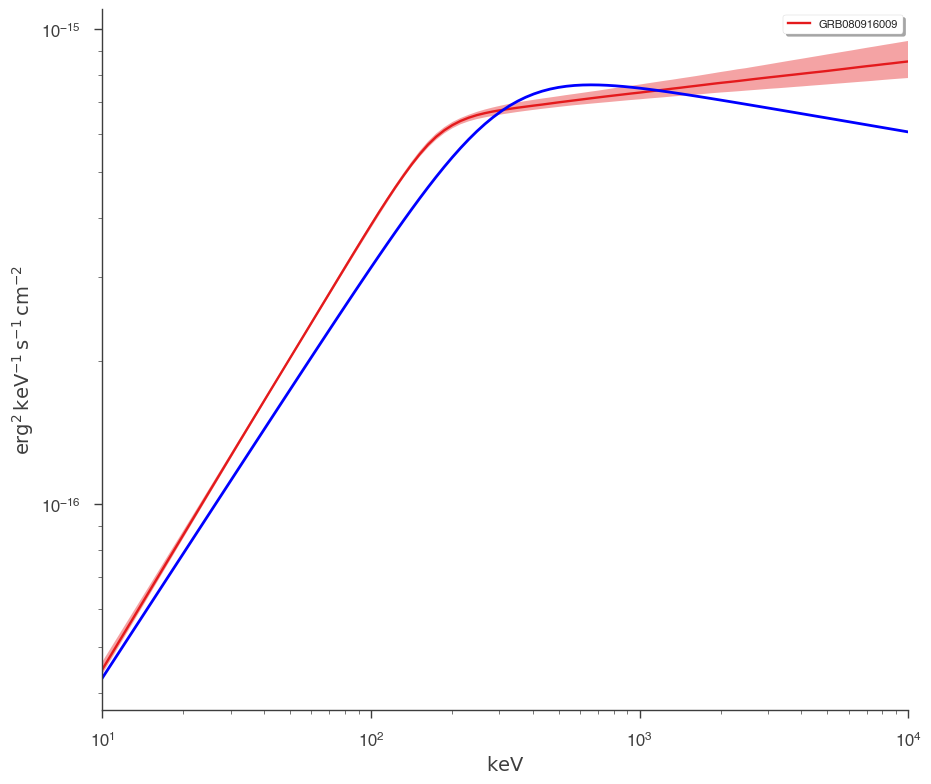

In [15]:
fig = plot_spectra(bayes.results, flux_unit="erg2/(cm2 s keV)")
ax = fig.get_axes()[0]
_ = ax.loglog(energy_grid, vFv, color="blue", label="catalog model")

## Time Resolved Analysis

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [16]:
n3 = time_series["n3"]

In [17]:
n3.create_time_bins(0, 60, method="bayesblocks", use_background=True, p0=0.2)

02:44:15 INFO      Created 15 bins via bayesblocks                                       ]8;id=867921;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=603838;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

<div class="alert alert-info">

**Note:** In the future, 3ML will provide an automated method to remove these unwanted spikes.

</div>


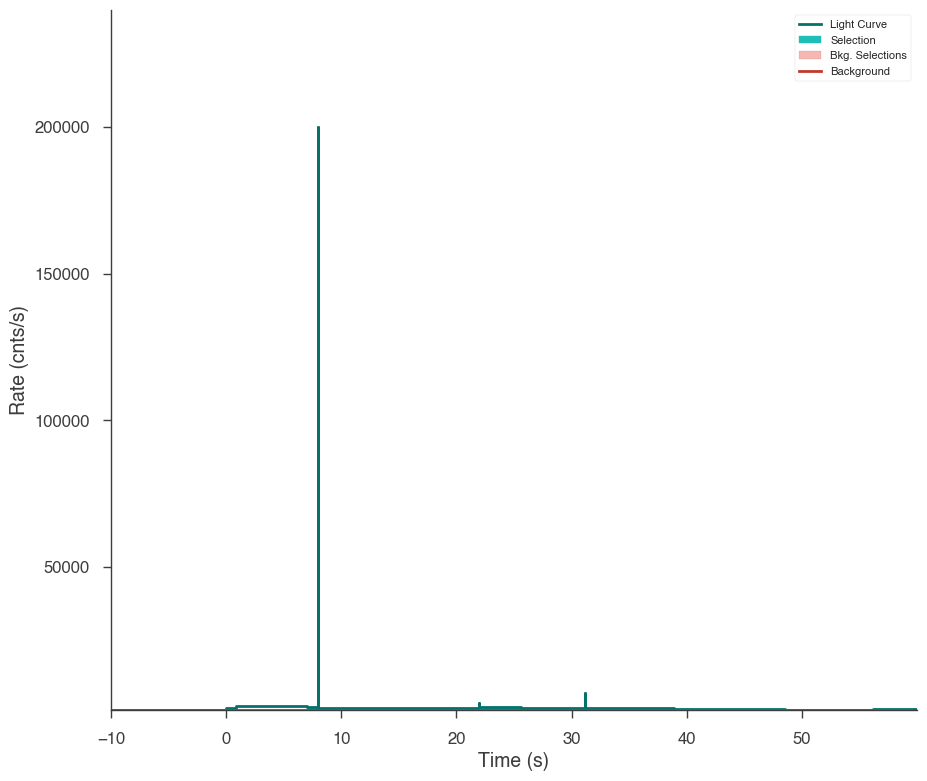

In [18]:
fig = n3.view_lightcurve(use_binner=True)

In [19]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):
    if w < 5e-2:
        bad_bins.append(i)


edges = [n3.bins.starts[0]]

for i, b in enumerate(n3.bins):
    if i not in bad_bins:
        edges.append(b.stop)

starts = edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method="custom")

         INFO      Created 12 bins via custom                                            ]8;id=797106;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=631600;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Now our light curve looks much more acceptable.

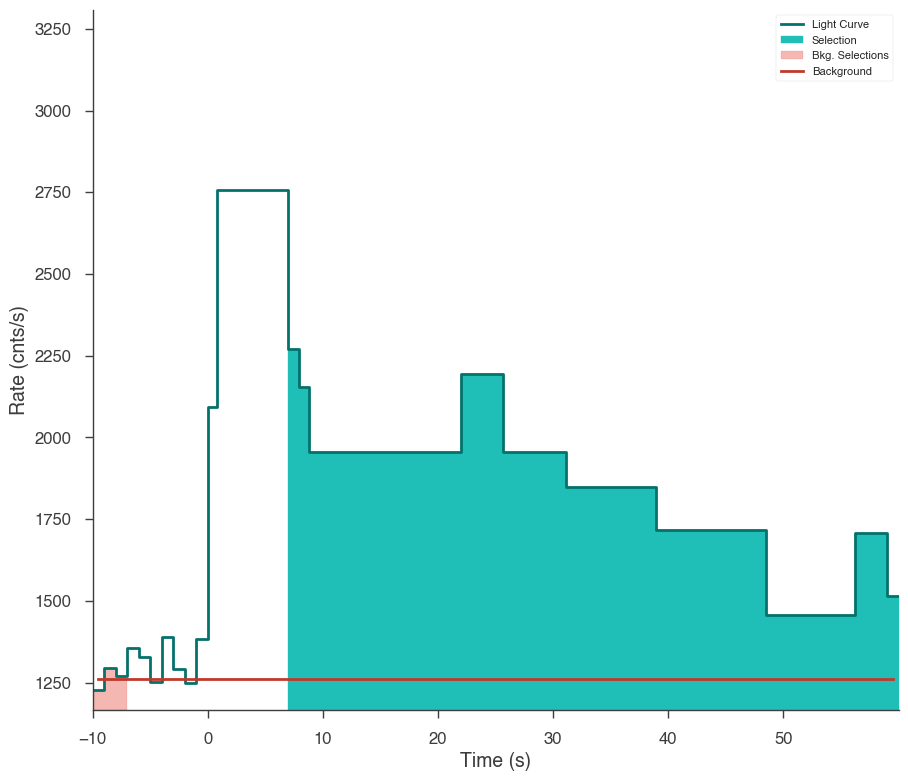

In [20]:
fig = n3.view_lightcurve(use_binner=True)

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above.

In [21]:
time_resolved_plugins = {}

for k, v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

02:44:16 INFO      Created 12 bins via custom                                            ]8;id=459648;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=76025;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

02:44:18 INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=56819;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=627384;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=270620;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=953086;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=452702;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=204003;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=791379;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=496315;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

02:44:20 INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=495130;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=883419;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [22]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound=-5, upper_bound=-1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (None, None)
band.K.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e3)
ps = PointSource("grb", 0, 0, spectral_shape=band)
band_model = Model(ps)

### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [23]:
models = []
results = []
analysis = []
for interval in range(12):
    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():
        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)

    # get some speed with share spectrum
    bayes.set_sampler("multinest", share_spectrum=True)
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=113366;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=234662;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=166890;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=879648;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=949910;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=140427;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=222791;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=801259;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=704171;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=812863;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 107 bins                                                          ]8;id=387787;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=247460;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=210971;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=541962;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -788.86847721951301      +/-  0.17994070559795927     
 Total Likelihood Evaluations:        16222
 Sampling finished. Exiting MultiNest



02:44:37 INFO      fit restored to maximum of posterior                                         ]8;id=995129;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=805979;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=816164;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=882601;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.59 -0.8 +0.28) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-5.4 -1.9 +0.5) x 10^-1,
grb.spectrum.main.Band.xp,(3.15 -0.26 +1.2) x 10^2,keV
grb.spectrum.main.Band.beta,-2.039 -0.6 +0.024,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval0,-285.659979
n3_interval0,-250.240157
n4_interval0,-268.017089
total,-803.917226


Values of statistical measures:

,statistical measures
AIC,1615.947766
BIC,1631.356584
DIC,1570.793065
PDIC,2.207884
log(Z),-342.601227


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=993401;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=891705;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=732871;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=985310;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=656695;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=661315;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=743283;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=902911;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=280161;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=693537;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=59741;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=664258;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=987745;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=126047;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2033.0989052031330      +/-  0.23334895896612692     
 Total Likelihood Evaluations:        23627
 Sampling finished. Exiting MultiNest



02:45:02 INFO      fit restored to maximum of posterior                                         ]8;id=731275;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=683234;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=563698;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=904453;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(9.17 -0.05 +0.04) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-3.30 -0.15 +0.04) x 10^-1,
grb.spectrum.main.Band.xp,(2.0564 -0.05 +0.0035) x 10^2,keV
grb.spectrum.main.Band.beta,-1.7228 +0.0029 +0.019,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval1,-700.858923
n3_interval1,-671.225790
n4_interval1,-663.744755
total,-2035.829468


Values of statistical measures:

,statistical measures
AIC,4079.772250
BIC,4095.181067
DIC,4034.048154
PDIC,1.471160
log(Z),-882.963636


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=341410;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=44648;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=729582;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=91832;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=447042;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=777378;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=767833;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=971417;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=685778;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=948759;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 115 bins                                                          ]8;id=930036;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=912024;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=283315;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=853270;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -910.41391658951522      +/-  0.18751430390868928     
 Total Likelihood Evaluations:        18306
 Sampling finished. Exiting MultiNest



02:45:20 INFO      fit restored to maximum of posterior                                         ]8;id=111356;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=199654;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=11689;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=642917;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.01 +0.14 +0.8) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.544 +0.034 +1.4) x 10^-1,
grb.spectrum.main.Band.xp,(3.59 -1.2 -0.35) x 10^2,keV
grb.spectrum.main.Band.beta,-1.750 +0.008 +0.11,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval2,-323.472046
n3_interval2,-288.294895
n4_interval2,-310.721664
total,-922.488605


Values of statistical measures:

,statistical measures
AIC,1853.090524
BIC,1868.499342
DIC,1807.796085
PDIC,2.022785
log(Z),-395.387740


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=992985;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=18902;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=564836;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=459983;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=986593;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=406844;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=282016;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=205718;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=793013;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=762614;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 109 bins                                                          ]8;id=101144;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=44072;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=965552;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=561704;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -790.34707708153928      +/-  0.17948410827082681     
 Total Likelihood Evaluations:        17700
 Sampling finished. Exiting MultiNest



02:45:34 INFO      fit restored to maximum of posterior                                         ]8;id=398691;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=515382;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=655062;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=336723;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.2 -0.6 +0.4) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.6 -1.7 +0.8) x 10^-1,
grb.spectrum.main.Band.xp,(3.0 -0.6 +0.9) x 10^2,keV
grb.spectrum.main.Band.beta,-2.17 +0.13 +0.33,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval3,-298.070142
n3_interval3,-242.102346
n4_interval3,-262.301688
total,-802.474177


Values of statistical measures:

,statistical measures
AIC,1613.061669
BIC,1628.470486
DIC,1570.548855
PDIC,1.908909
log(Z),-343.243374


02:45:35 INFO      Range 9-900 translates to channels 5-124                                    ]8;id=928194;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=856727;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=275204;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=320085;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=437822;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=948391;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=880809;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=923233;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=94885;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=892084;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=499128;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=990055;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=684843;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=39335;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2270.7081519873573      +/-  0.19891690452438110     
 Total Likelihood Evaluations:        21373
 Sampling finished. Exiting MultiNest



02:45:53 INFO      fit restored to maximum of posterior                                         ]8;id=499075;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=521177;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=752625;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=100329;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.05 -0.09 +0.12) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.82 -0.32 +0.4) x 10^-1,
grb.spectrum.main.Band.xp,(4.0 +/- 0.5) x 10^2,keV
grb.spectrum.main.Band.beta,-1.97 -0.05 +0.08,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval4,-778.483771
n3_interval4,-757.127314
n4_interval4,-746.725840
total,-2282.336925


Values of statistical measures:

,statistical measures
AIC,4572.787164
BIC,4588.195982
DIC,4526.921037
PDIC,3.060461
log(Z),-986.156020


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=876554;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=942433;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=356423;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=108164;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=758978;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=342526;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=134161;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=541496;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=708399;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=438963;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=495463;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=318544;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=358172;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=798838;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1574.1610428864942      +/-  0.19782010356138874     
 Total Likelihood Evaluations:        18434
 Sampling finished. Exiting MultiNest



02:46:07 INFO      fit restored to maximum of posterior                                         ]8;id=860363;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=397669;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=158796;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=516431;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.78 -0.22 +0.13) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.17 -0.7 +0.30) x 10^-1,
grb.spectrum.main.Band.xp,(4.3 -0.4 +0.8) x 10^2,keV
grb.spectrum.main.Band.beta,-2.21 -0.25 +0.05,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval5,-537.080714
n3_interval5,-523.620231
n4_interval5,-527.856409
total,-1588.557354


Values of statistical measures:

,statistical measures
AIC,3185.228023
BIC,3200.636840
DIC,3136.304806
PDIC,2.796432
log(Z),-683.649455


02:46:08 INFO      Range 9-900 translates to channels 5-124                                    ]8;id=884660;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=40598;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=887884;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=372248;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=383498;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=984517;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=244885;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=377933;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=733424;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=381413;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=789782;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=918965;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=250330;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=490802;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1758.1100072195054      +/-  0.19987362522070215     
 Total Likelihood Evaluations:        19270
 Sampling finished. Exiting MultiNest



02:46:23 INFO      fit restored to maximum of posterior                                         ]8;id=951176;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=15033;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=425873;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=918046;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.037 -0.007 +0.21) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.69 -0.10 +0.6) x 10^-1,
grb.spectrum.main.Band.xp,(4.12 -0.8 +0.04) x 10^2,keV
grb.spectrum.main.Band.beta,-2.223 +0.022 +0.13,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval6,-609.417907
n3_interval6,-584.156316
n4_interval6,-576.474357
total,-1770.048580


Values of statistical measures:

,statistical measures
AIC,3548.210475
BIC,3563.619292
DIC,3499.805505
PDIC,1.958185
log(Z),-763.537475


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=447169;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=751614;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=622132;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=719440;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=533733;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=625718;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=896074;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=276544;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=772631;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=454403;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=71208;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=729013;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=728567;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=665730;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1939.6042397715983      +/-  0.19422082038017352     
 Total Likelihood Evaluations:        19673
 Sampling finished. Exiting MultiNest



02:46:36 INFO      fit restored to maximum of posterior                                         ]8;id=299149;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=152002;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=634749;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=294615;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.69 -0.11 +0.07) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.034 -0.06 +0.029,
grb.spectrum.main.Band.xp,(4.25 -0.34 +0.8) x 10^2,keV
grb.spectrum.main.Band.beta,-2.26 -0.4 +0.07,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval7,-662.171408
n3_interval7,-640.937057
n4_interval7,-650.344046
total,-1953.452511


Values of statistical measures:

,statistical measures
AIC,3915.018337
BIC,3930.427155
DIC,3868.451165
PDIC,3.047755
log(Z),-842.359418


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=725419;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=253615;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=576816;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=984373;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=359423;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=806432;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=487632;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=221063;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=548710;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=717677;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=184325;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=364313;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=299061;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=692484;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2054.1136024336256      +/-  0.18912858865049170     
 Total Likelihood Evaluations:        17930
 Sampling finished. Exiting MultiNest



02:46:48 INFO      fit restored to maximum of posterior                                         ]8;id=683583;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=776712;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=649767;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=48854;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.54 -0.15 +0.09) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.5 -0.7 +0.5) x 10^-1,
grb.spectrum.main.Band.xp,(3.70 -0.28 +0.8) x 10^2,keV
grb.spectrum.main.Band.beta,-2.30 -0.4 +0.08,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval8,-702.101443
n3_interval8,-698.445379
n4_interval8,-666.159409
total,-2066.706231


Values of statistical measures:

,statistical measures
AIC,4141.525776
BIC,4156.934593
DIC,4098.195278
PDIC,3.222380
log(Z),-892.090203


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=675460;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=610172;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=194804;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=758821;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=280825;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=521604;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=705991;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=415576;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=670931;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=7115;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=101636;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=158199;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=706257;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=759867;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1879.3971674099348      +/-  0.14761797415473285     
 Total Likelihood Evaluations:        12237
 Sampling finished. Exiting MultiNest



02:46:56 INFO      fit restored to maximum of posterior                                         ]8;id=287900;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=264977;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=986064;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=124655;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.08 -0.05 +2.8) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.7 -0.5 +5) x 10^-1,
grb.spectrum.main.Band.xp,(1.15 -0.6 +0.08) x 10^2,keV
grb.spectrum.main.Band.beta,-1.85 -0.16 +0.15,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval9,-648.512174
n3_interval9,-616.936054
n4_interval9,-616.260581
total,-1881.708809


Values of statistical measures:

,statistical measures
AIC,3771.530932
BIC,3786.939749
DIC,3683.257841
PDIC,-63.710289
log(Z),-816.211819


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=894110;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=341251;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=941243;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=752252;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=492425;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=693056;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=469531;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=153457;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=143004;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=373084;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=934208;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=661560;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=389345;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=116624;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1323.0247476824557      +/-  0.17062399878787052     
 Total Likelihood Evaluations:        14914
 Sampling finished. Exiting MultiNest



02:47:06 INFO      fit restored to maximum of posterior                                         ]8;id=358609;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=169868;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=339180;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=920289;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.0 -0.4 +0.8) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-7.6 -1.5 +1.8) x 10^-1,
grb.spectrum.main.Band.xp,(2.2 -0.6 +0.8) x 10^2,keV
grb.spectrum.main.Band.beta,-1.95 -0.5 +0.19,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval10,-460.829838
n3_interval10,-437.709163
n4_interval10,-433.179908
total,-1331.718909


Values of statistical measures:

,statistical measures
AIC,2671.551132
BIC,2686.959950
DIC,2631.597027
PDIC,-2.797880
log(Z),-574.582347


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=859635;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=383606;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=581376;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=261860;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=234109;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=670203;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=377492;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=106755;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=694688;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=75322;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=440982;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=966054;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=839442;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=746935;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -812.97253496362134      +/-  0.15167373353317476     
 Total Likelihood Evaluations:        12300
 Sampling finished. Exiting MultiNest



02:47:15 INFO      fit restored to maximum of posterior                                         ]8;id=789634;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=442548;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=705496;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=626534;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.7 -0.6 +1.6) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-5.0 -2.3 +2.5) x 10^-1,
grb.spectrum.main.Band.xp,(1.31 -0.35 +0.17) x 10^2,keV
grb.spectrum.main.Band.beta,-2.12 -0.12 +0.28,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval11,-292.351706
n3_interval11,-272.376712
n4_interval11,-255.846943
total,-820.575361


Values of statistical measures:

,statistical measures
AIC,1649.264037
BIC,1664.672855
DIC,1616.359795
PDIC,-0.386673
log(Z),-353.069486


### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

         INFO      fit restored to median of posterior                                          ]8;id=821221;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=450364;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=605727;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=842210;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

02:47:16 INFO      fit restored to median of posterior                                          ]8;id=328257;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=890025;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

02:47:17 INFO      fit restored to median of posterior                                          ]8;id=38383;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=426593;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

02:47:18 INFO      fit restored to median of posterior                                          ]8;id=413218;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=915631;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

02:47:19 INFO      fit restored to median of posterior                                          ]8;id=678485;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=820729;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=316255;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=128990;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

02:47:20 INFO      fit restored to median of posterior                                          ]8;id=680454;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=309402;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=751587;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=50799;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

02:47:21 INFO      fit restored to median of posterior                                          ]8;id=53044;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=923445;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

02:47:22 INFO      fit restored to median of posterior                                          ]8;id=718199;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=208725;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=168625;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=870661;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

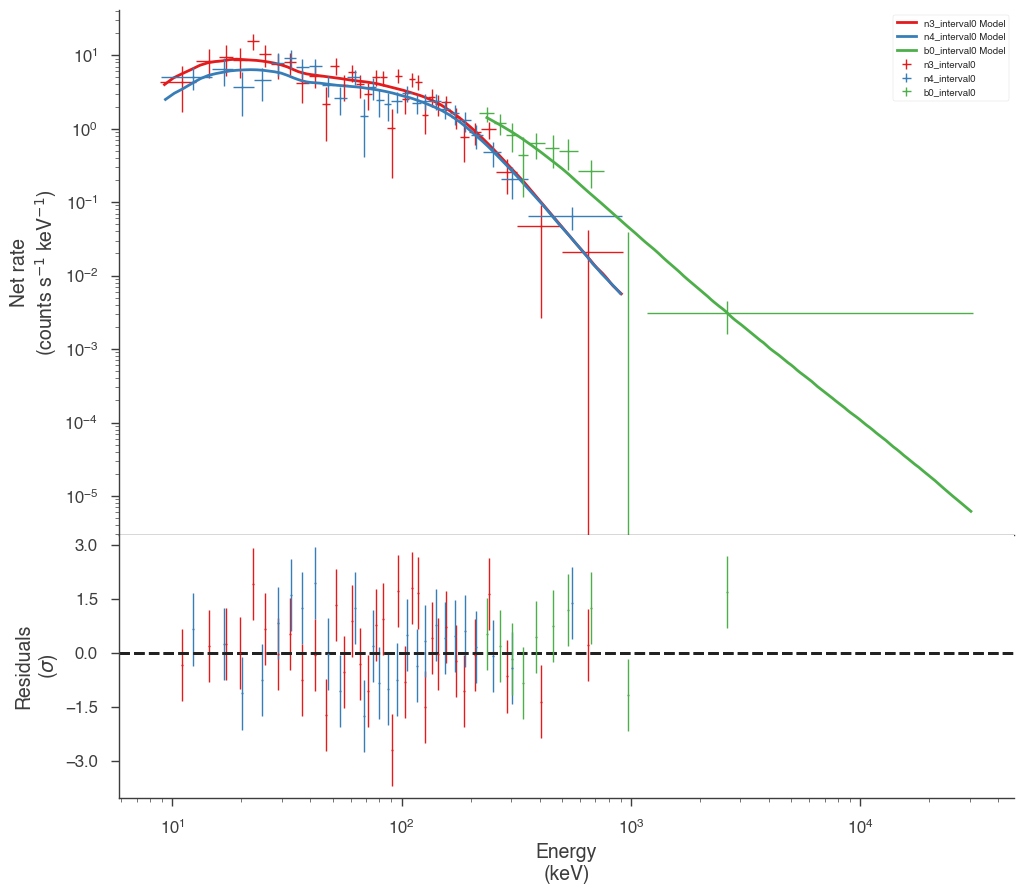

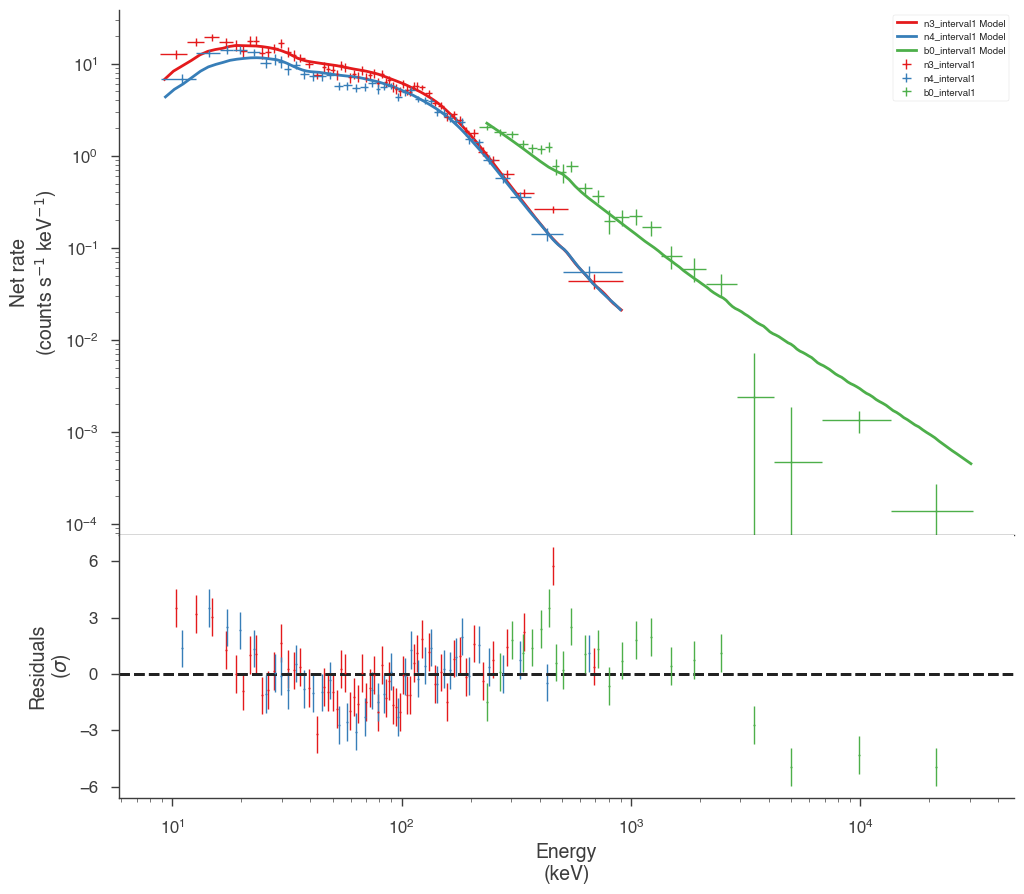

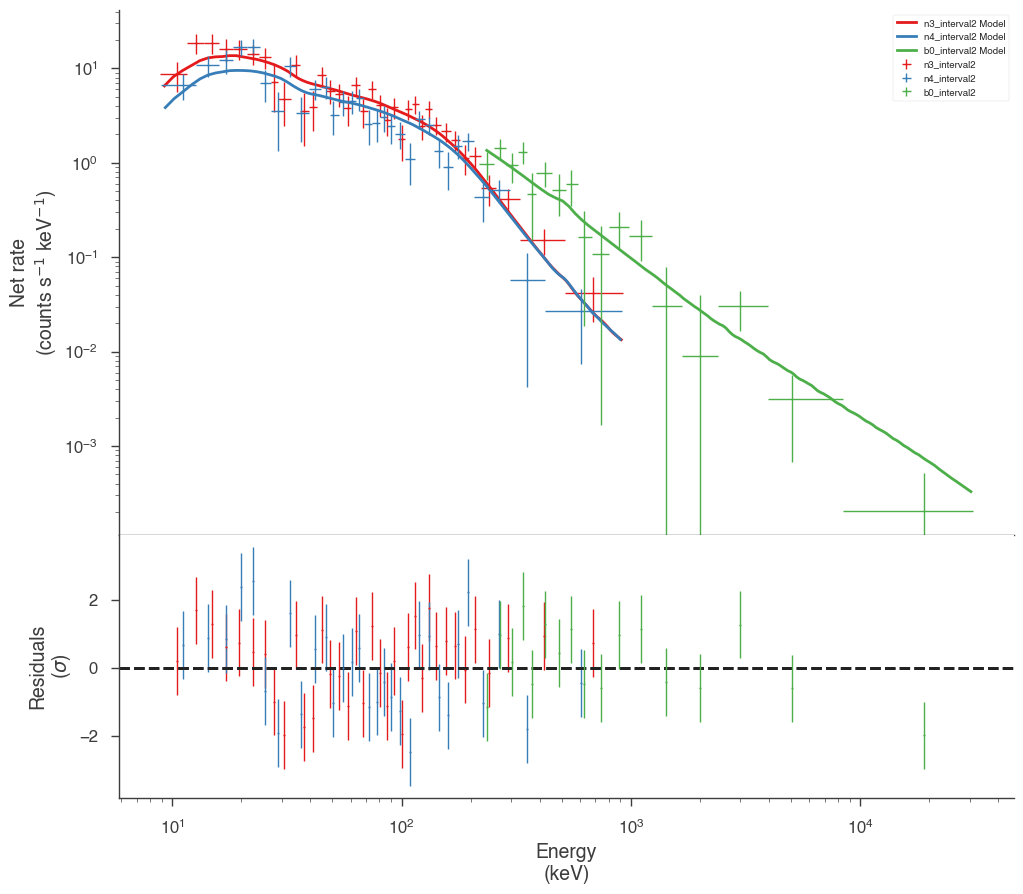

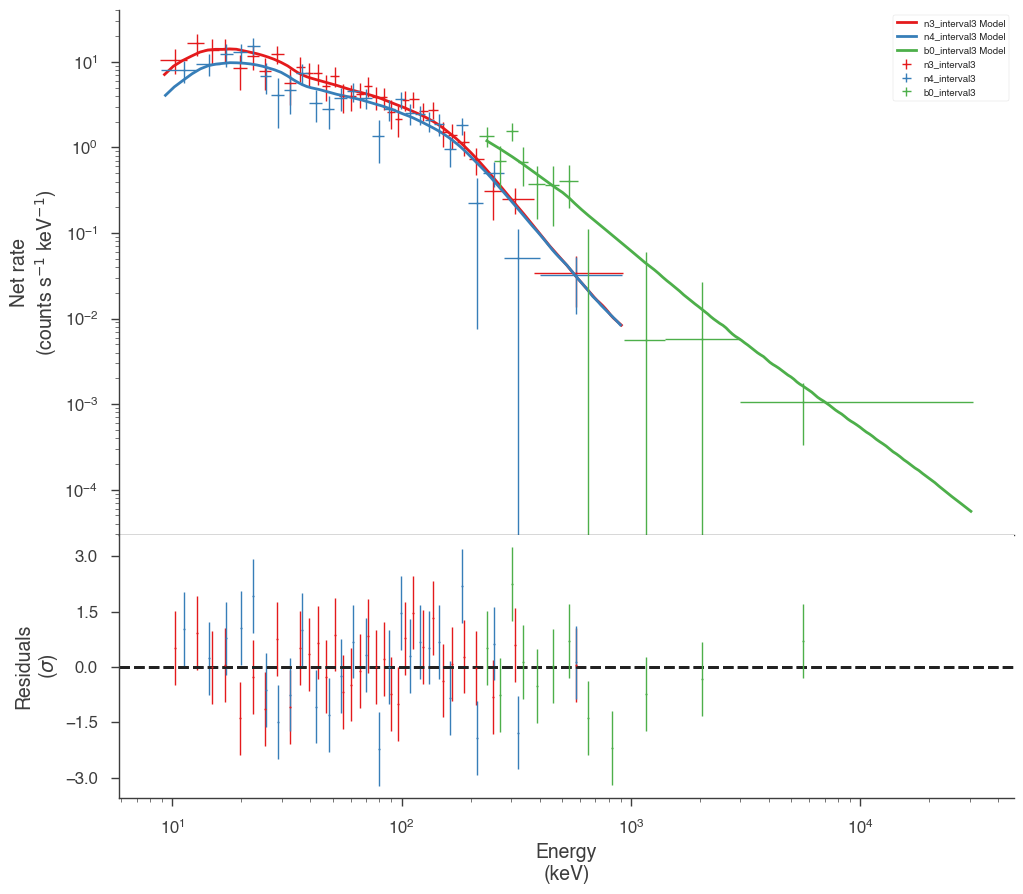

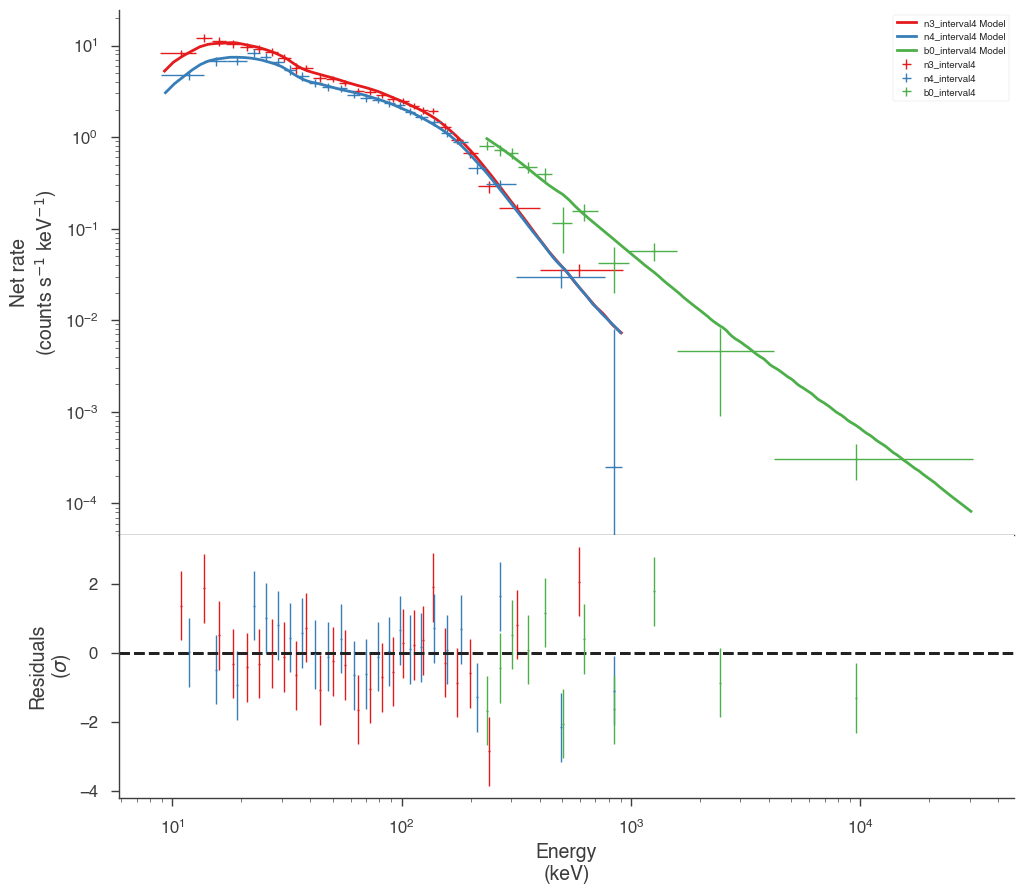

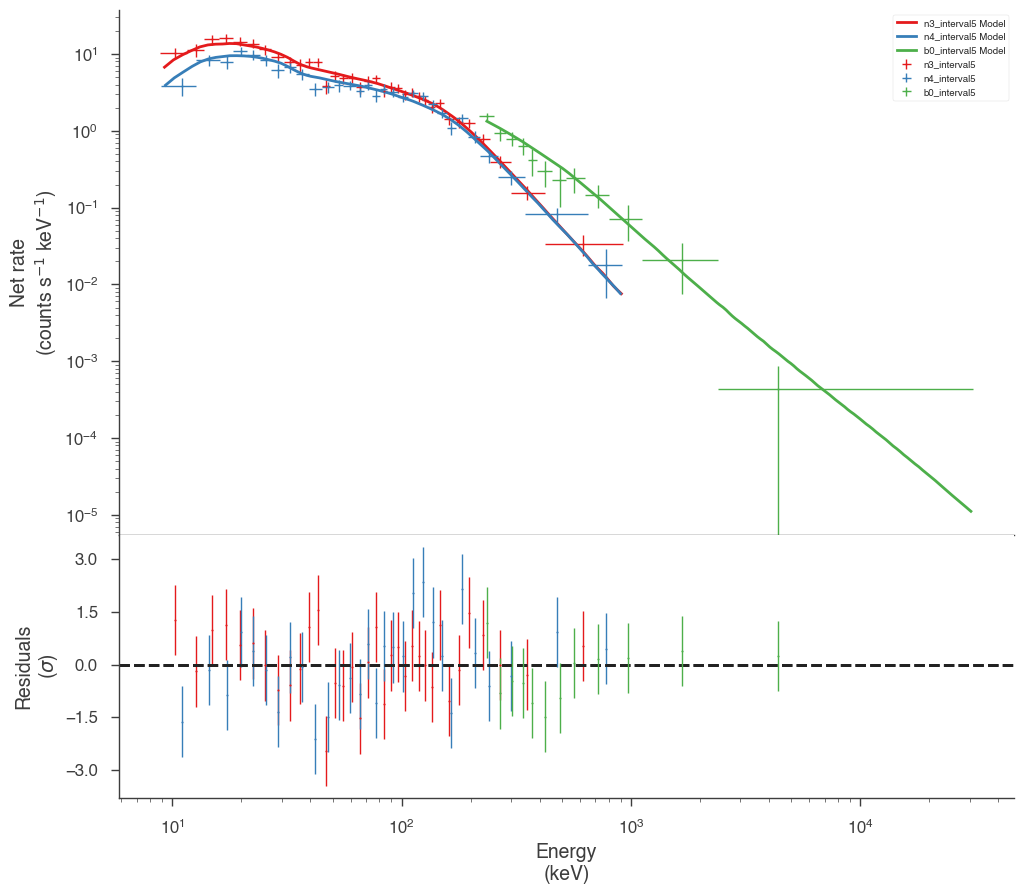

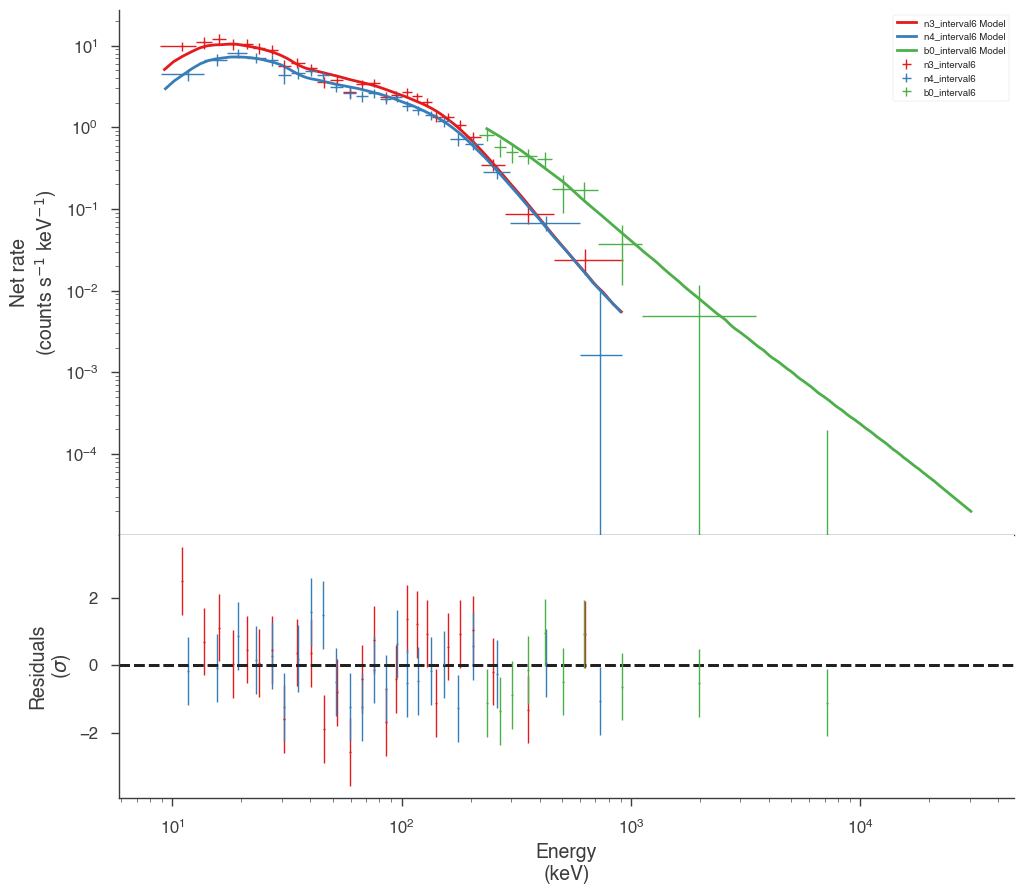

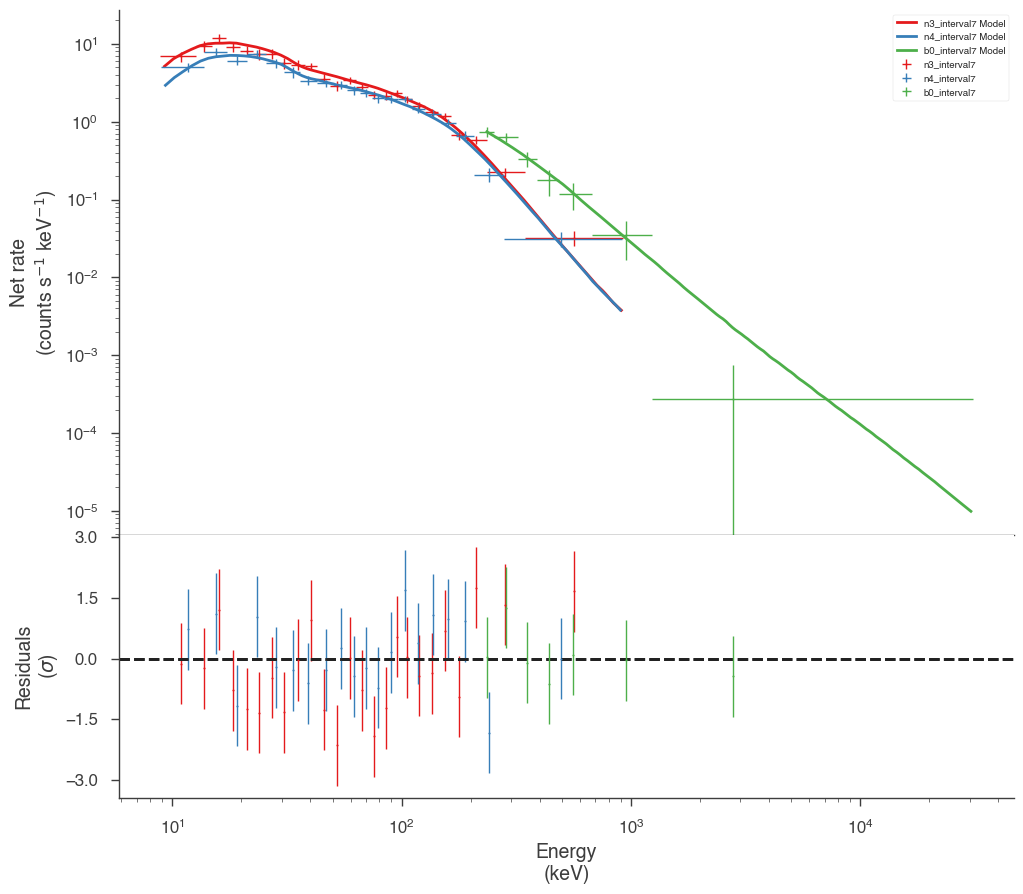

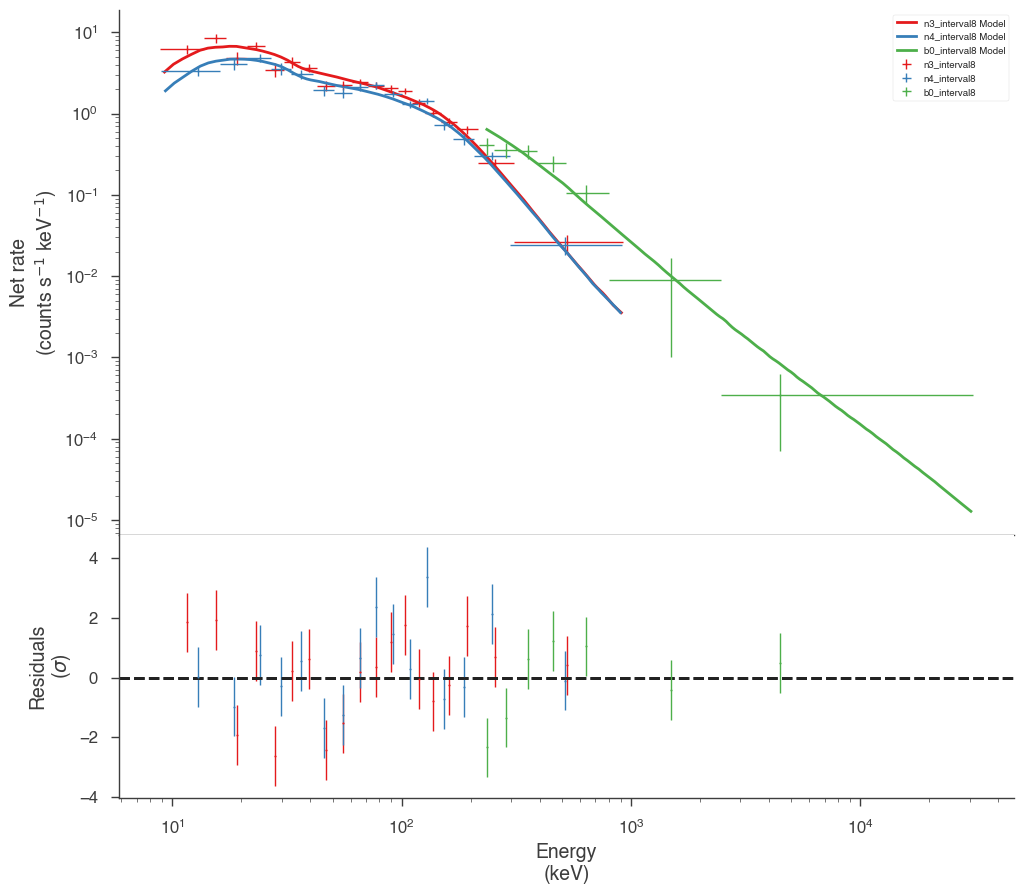

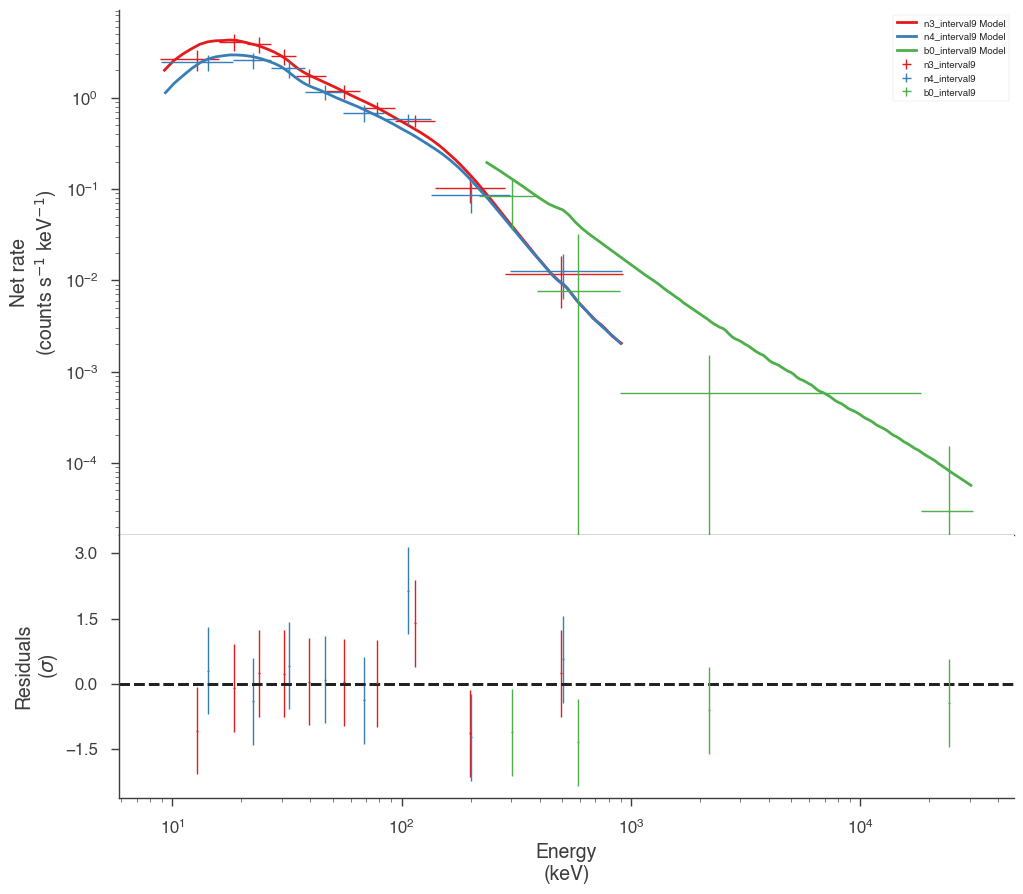

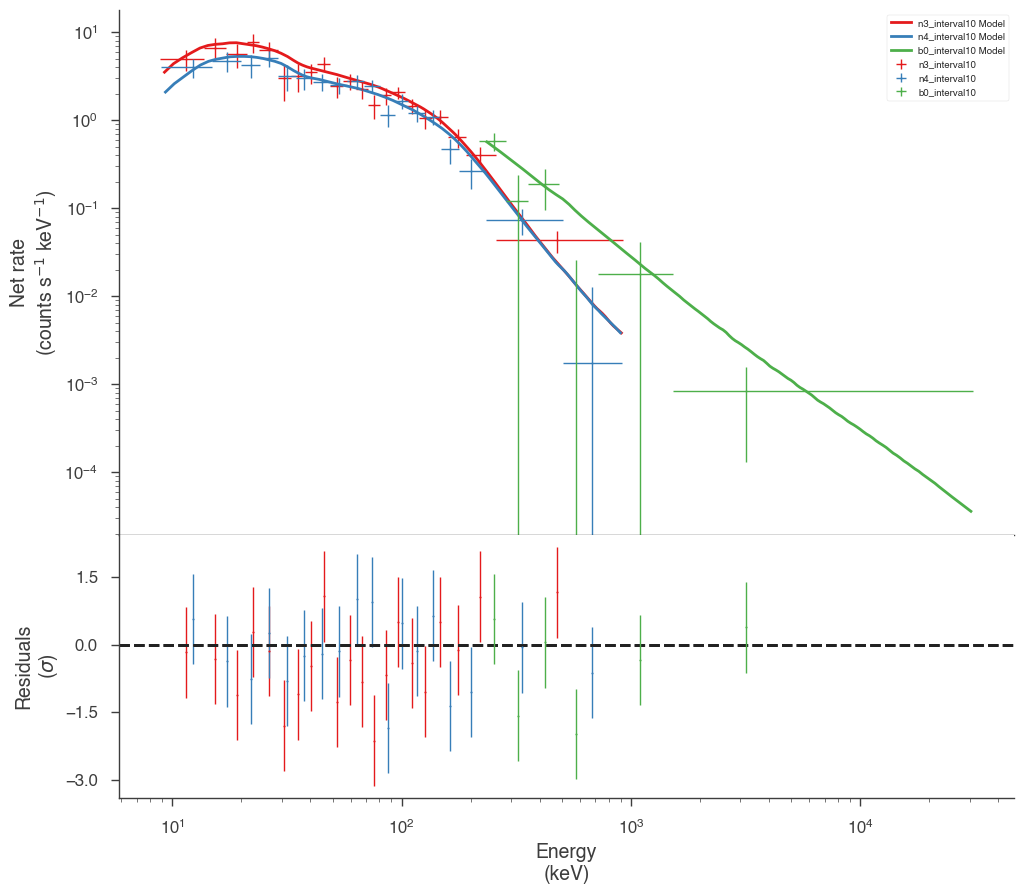

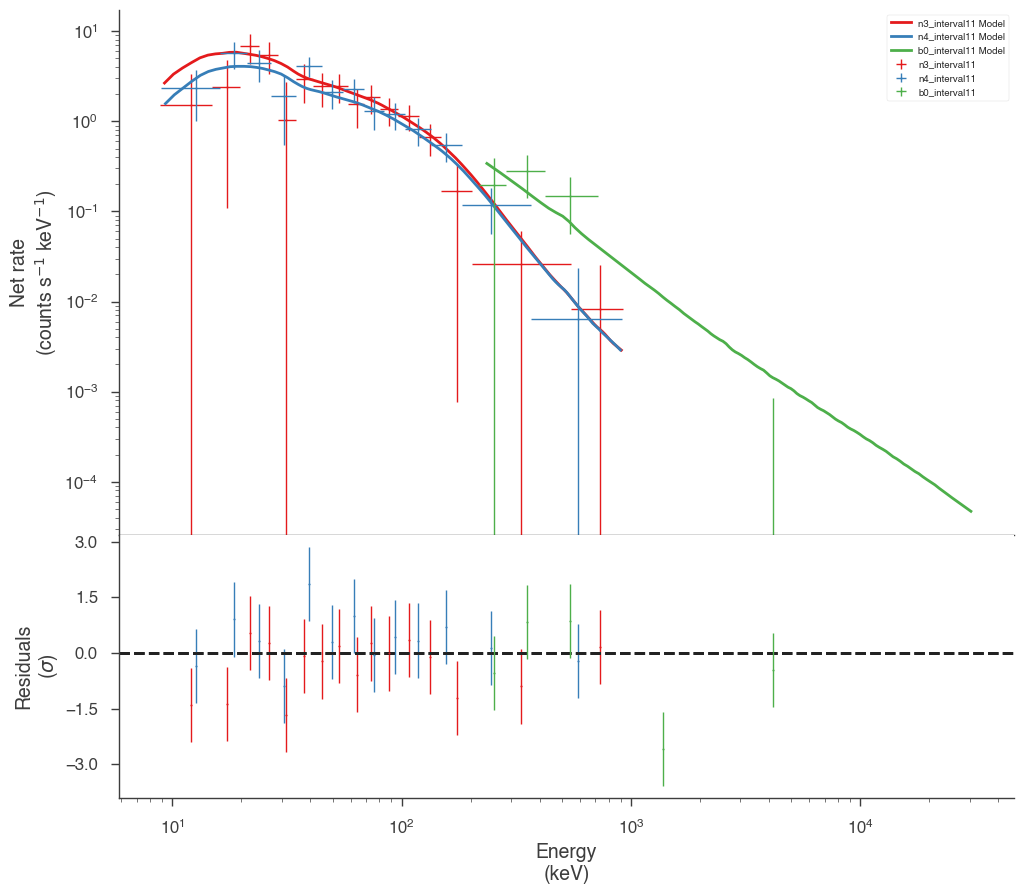

In [24]:
for a in analysis:
    a.restore_median_fit()
    _ = display_spectrum_model_counts(a, min_rate=[20, 20, 20], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

processing Bayesian analyses:   0%|          | 0/12 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

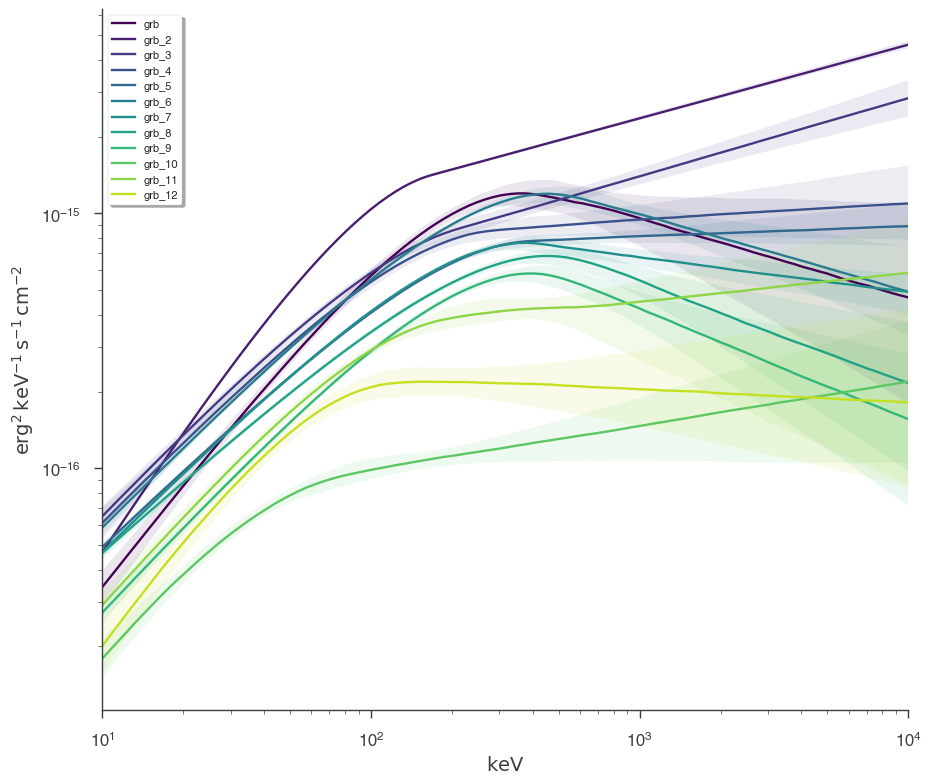

In [25]:
fig = plot_spectra(
    *[a.results for a in analysis[::1]],
    flux_unit="erg2/(cm2 s keV)",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1),
)

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data.